In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Charger le dataset Food-101 (train uniquement)
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

# Récupérer les noms des classes
class_names = info.features['label'].names[:10]

# Filtrer le dataset pour ne garder que les 10 premières classes
def filter_classes(image, label):
    return tf.reduce_any([label == i for i in range(10)])

filtered_dataset = dataset.filter(filter_classes)

# Diviser en train/validation (80% - 20%)
train_split = 0.8
dataset_size = sum(1 for _ in filtered_dataset)
train_size = int(train_split * dataset_size)

train_ds = filtered_dataset.take(train_size)
val_ds = filtered_dataset.skip(train_size)

# Fonction de prétraitement des images
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Normalisation [0,1]
    return image, label



In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
# Définition du modèle CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Regularisation
    tf.keras.layers.Dense(10, activation='softmax')  # 10 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
 # Reduce batch size for better generalization
batch_size = 16
# Apply preprocessing
train_dataset = train_ds.map(preprocess).batch(batch_size).shuffle(1000)
val_dataset = val_ds.map(preprocess).batch(batch_size)

In [7]:
# Compilation du modèle
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [8]:
# Affichage du résumé du modèle
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,247,242 (84.87 MB)

 Trainable params: 22,247,242 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Entraînement du modèle
epochs = 10

history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1)


Epoch 1/10
    375/Unknown 84s 26ms/step - accuracy: 0.1773 - loss: 2.2920

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


375/375 ━━━━━━━━━━━━━━━━━━━━ 169s 254ms/step - accuracy: 0.1775 - loss: 2.2915 - val_accuracy: 0.3173 - val_loss: 1.9336
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 194s 250ms/step - accuracy: 0.3280 - loss: 1.8984 - val_accuracy: 0.3800 - val_loss: 1.7858
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 196s 240ms/step - accuracy: 0.3951 - loss: 1.6957 - val_accuracy: 0.4167 - val_loss: 1.6693
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 263s 374ms/step - accuracy: 0.4996 - loss: 1.4520 - val_accuracy: 0.4340 - val_loss: 1.6416
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 206s 241ms/step - accuracy: 0.5941 - loss: 1.1876 - val_accuracy: 0.4093 - val_loss: 1.7947
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 215s 287ms/step - accuracy: 0.7154 - loss: 0.8222 - val_accuracy: 0.4207 - val_loss: 1.9646
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 194s 317ms/step - accuracy: 0.8298 - loss: 0.5348 - val_accuracy: 0.3960 - val_loss: 2.2467
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 175s 261ms/step - accuracy: 0.8646 - loss: 0.40

In [11]:
# Évaluation du modèle
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - accuracy: 0.4102 - loss: 2.9226
Validation Accuracy: 0.4007


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


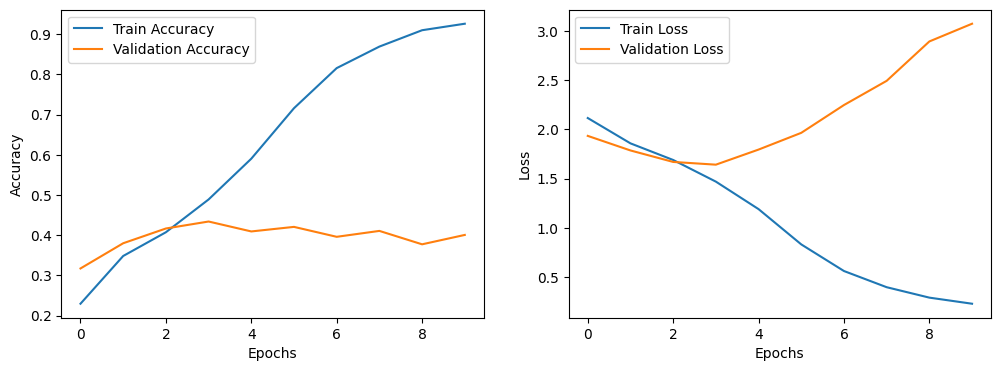

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy and loss after fine-tuning
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 189ms/step
                   precision    recall  f1-score   support

        apple_pie       0.31      0.26      0.28       152
   baby_back_ribs       0.65      0.38      0.48       135
          baklava       0.34      0.39      0.36       138
   beef_carpaccio       0.50      0.54      0.52       155
     beef_tartare       0.29      0.29      0.29       157
       beet_salad       0.34      0.48      0.40       144
         beignets       0.49      0.71      0.58       170
         bibimbap       0.58      0.51      0.54       166
    bread_pudding       0.22      0.16      0.18       144
breakfast_burrito       0.27      0.23      0.25       139

         accuracy                           0.40      1500
        macro avg       0.40      0.39      0.39      1500
     weighted avg       0.40      0.40      0.39      1500


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


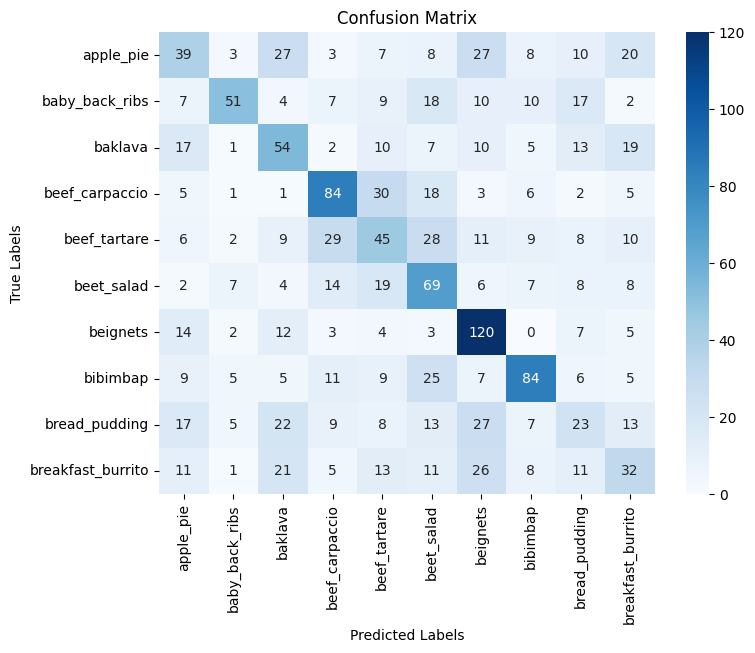

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = tf.concat([labels for _, labels in val_dataset], axis=0)
y_pred = tf.argmax(model.predict(val_dataset), axis=1)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()